In [3]:
import numpy as np
import math, random, string
import os, sys
from h5py import File
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [4]:
fs=1024*16 #why? - blackmann window step size x ? 
NFFT = int(fs/1) #what's this number?
NOVL = int(NFFT*15./16) #what's this number?
batch_size = 2*64 #why
sec = 32
tot_length = sec + 2
input_length = tot_length - 10 #10 sec warning
im_width = int(fs*(input_length-1)/((fs*2-NOVL*2)/2) + 1)
tot_width = int(fs*(tot_length-1)/((fs*2-NOVL*2)/2) + 1)
epochs = 350


In [5]:
print(im_width, tot_width)

369 529


In [6]:
from multiprocessing import Pool, Queue

q1 = Queue(maxsize=1000)
q2 = Queue(maxsize=1000)

In [7]:
with File('train_im_merger_pred_32.h5','r') as f:
    print("Length of full train set:",len(f['im']))
    idx1 = list(np.where(f['target'][:]==1)[0])
    params1 = f['params'][idx1]
    idx0 = list(np.where(f['target'][:]==0)[0])
    params0 = f['params'][idx0]
    print("Number of train samples labelled 1:",params1.shape,"Number of train samples labelled 0:", params0.shape)
    #print("Params with label 1:",params1)
    #print("Params with label 0:",params0)
    #print(f['im'][idx0])
with File('test_im_merger_pred_32.h5','r') as f:
    print("Length of full test set:",len(f['im']))
    idx1 = list(np.where(f['target'][:]==1)[0])
    params1 = f['params'][idx1]
    idx0 = list(np.where(f['target'][:]==0)[0])
    params0 = f['params'][idx0]
    print("Number of test samples labelled 1:",params1.shape,"Number of test samples labelled 0:", params0.shape)
    #print("Params with label 1:",params1)
    #print("Params with label 0:",params0)
    #print(f['im'][idx0])

Length of full train set: 20000
Number of train samples labelled 1: (13560, 4) Number of train samples labelled 0: (6440, 4)
Length of full test set: 5000
Number of test samples labelled 1: (4040, 4) Number of test samples labelled 0: (960, 4)


In [8]:
def load1(idx): 
    np.random.seed(idx) #Set random state for reproducibility
    with File('train_im_merger_pred_32.h5', 'r') as f_train: #open train set
        length = f_train['im'].shape[0]
        for _ in tqdm(range(epochs)): #Number of images you want in your queue
            indices = np.random.choice(length, size=batch_size, replace=False) #random sample of 256 indices
            tmp = np.zeros((batch_size, 3, 130, im_width), dtype = np.float32) #create a 256x3x130xim_width matrix of 0s
            target = np.zeros(batch_size, dtype=np.int32) #create a 256 length list of 0s
            for i in (range(batch_size)): #run loop batch_size times
                start = np.random.randint(tot_width - im_width) #random number 
                tmp[i, :] = f_train['im'][indices[i]][:,20:150,start :start+im_width] #ith element is a 3x130x113 image
                target[i] = f_train['target'][indices[i]]
            out = [np.float32(tmp), np.float32(target)]
            q1.put(out)


def worker1():
    with Pool(num_t) as p:
        p.map(load1, range(num_t))

In [9]:
def load2(idx):
    np.random.seed(idx)
    with File('test_im_merger_pred_32.h5', 'r') as f_test:
        length = f_test['im'].shape[0]
        for _ in tqdm(range(epochs)):
            indices = np.random.choice(length, size=batch_size, replace=False)
            tmp = np.zeros((batch_size, 3, 130,im_width), dtype = np.float32)
            target = np.zeros(batch_size, dtype=np.int32)
            for i in (range(batch_size)):
                start = np.random.randint(tot_width - im_width)
                tmp[i, :] = f_test['im'][indices[i]][:,20:150,start:start+im_width ]
                target[i] = f_test['target'][indices[i]]
            out = [np.float32(tmp), np.float32(target)]
            q2.put(out)

def worker2():
    with Pool(num_t) as p:
        p.map(load2, range(num_t))

In [ ]:
load1(150)
load2(150)


In [15]:
import torch.multiprocessing
#p1 = torch.multiprocessing.Process(target=load1, args=(100,)) #what is going on here?
#p1.start()
#p1.join()
#p2 = torch.multiprocessing.Process(target=load2, args=(100,))
#p2.start()
#p2.join()

In [24]:
print("Q1 size:",q1.qsize(), "and total number of train samples:",q1.qsize()*batch_size)
print("Q2 size:",q2.qsize(), "and total number of test samples:",q2.qsize()*batch_size)

Q1 size: 350 and total number of train samples: 44800
Q2 size: 350 and total number of test samples: 44800


In [30]:
directory_name = os.path.abspath(os.path.dirname(sys.argv[0]))
save_directory_name = 'Data from BW/checkpoints'

sample_directory_name = 'Data from BW/samples'
suffix = ''.join([random.choice(string.ascii_letters + string.digits) for n in range(16)])

In [31]:
import torch, gc
import torch.nn as nn
import torch.multiprocessing
gc.collect()
torch.cuda.empty_cache()
out_stream = open('loss_'+suffix+'.out', 'w')

from torchvision import models

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 1) #Change fully connected layer
model.cuda()
print("No. of parameters:",len(list(model.parameters())))
model = nn.DataParallel(model, device_ids=[0,1])
model = nn.Sequential(model,nn.Sigmoid()) #
alpha = 1e-5
optimizer = torch.optim.SGD(model.parameters(), lr=alpha) #Change optimizer: Adam or SGD
criterion = nn.BCEWithLogitsLoss() #Maybe change loss function

No. of parameters: 161



Total Training loss: 231.62673610448837
Total Validation loss 211.91114151477814
Average Training Accuracy: 0.32272321428571427
Average Validation Accuracy: 0.19263392857142858


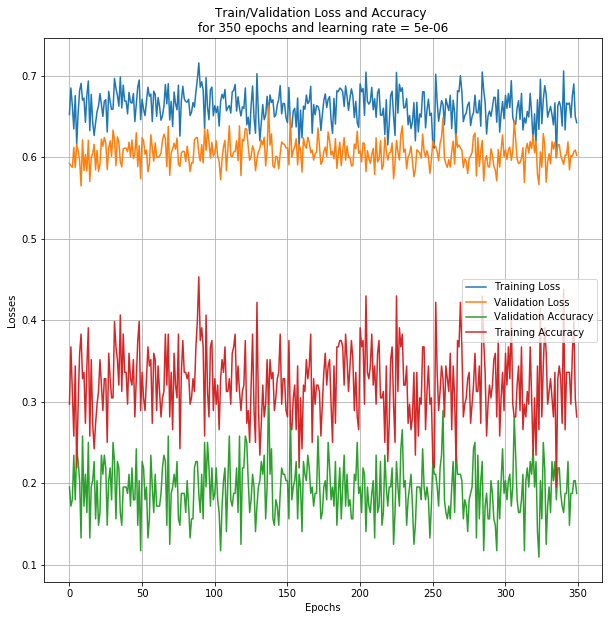

In [32]:
plt.figure(figsize=(10,10))
losses = []
losses_t = []
train_acc = []
val_acc = []
total_train_loss = 0
total_val_loss = 0
for e in tqdm(range(epochs)):
    model.train()
    pair = q1.get()
    inp = torch.tensor(pair[0], requires_grad = True).cuda() 
    out = torch.tensor(pair[1]).cuda() 
    optimizer.zero_grad() #clear previous gradients
    pred = model(inp) #forward pass
    pred = pred.view((-1)) #reshape to appropriate columns but unknown number of rows
    acc1 = accuracy_score(out.cpu().numpy(), np.round(pred.cpu().detach().numpy(),0))
    train_acc.append(acc1)
    loss = criterion(pred, out) #loss between predicted and y - train
    loss.backward() #backpropogation - calculate gradient
    optimizer.step() #update
    losses.append(loss.item())
    total_train_loss += loss.item()
    ########## Validation ##########
    with torch.no_grad():
        model.eval() #Switch to validation mode
        t_pair = q2.get() #Get a batch from test queue
        t_inp = torch.tensor(t_pair[0]).cuda() #Input test set
        t_out = torch.tensor(t_pair[1]) #Bunch of 1s and 0s 
        pred_t = model(t_inp)
        pred_t = pred_t.view((-1))
        acc2 = accuracy_score(t_out.cpu().numpy(), np.round(pred_t.cpu().detach().numpy(),0))
        val_acc.append(acc2)
        loss_t = criterion(pred_t.cpu(),t_out)
        losses_t.append(loss_t.item())
        #out_stream.write(str((e, loss.item(), loss_t.item()))+'\n')
        #out_stream.flush()
        total_val_loss += loss_t.item()
        
plt.plot(losses,label="Training Loss")
plt.plot(losses_t,label="Validation Loss")
plt.plot(val_acc, label="Validation Accuracy")
plt.plot(train_acc, label="Training Accuracy")
plt.title("Train/Validation Loss and Accuracy \nfor {} epochs and learning rate = {}".format(epochs,alpha))
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.grid(b=True)
plt.legend()
print("Total Training loss:", total_train_loss)
print("Total Validation loss", total_val_loss)
print("Average Training Accuracy:", np.sum(train_acc)/epochs)
print("Average Validation Accuracy:", np.sum(val_acc)/epochs)

In [22]:
out, pred


(tensor([0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
         0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.,
         0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
         0., 1.], device='cuda:0'),
 tensor([0.0000, 0.0000, 1.7252, 2.0032, 0.0000, 1.6334, 1.7801, 0.0000, 1.5317,
         2.0861, 1.6341, 1.6693, 1.5761, 0.0000, 0.0000, 1.7461, 1.5482, 1.7138,
         0.0000, 2.1081, 1.7630, 0.0000, 1.6767, 2.0631, 1.5798, 1.7137, 0.0000,
         2.1997, 1.4893, 1.7033, 0.0000, 1.8023, 0.0000, 1.3990, 0.0000, 1.2131,
         0.0000, 1.6027, 0.0000, 1.9263, 1.6964, 0.0000, 1.5851, 1.7317, 

In [ ]:
torch.save(model.state_dict(), save_directory_name+'/model_'+str(e)+'_'+suffix+'.pth')
torch.save(optimizer.state_dict(), save_directory_name+'/optim_'+str(e)+'_'+suffix+'.opt')


In [ ]:
print(model)